In [1]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt
import numpy as np

# Make sure we can import from src/ without installing the package
PROJECT_ROOT = Path.cwd().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from trader.dataset.dataset import Dataset

In [2]:
btc_1m = Dataset.from_csv(PROJECT_ROOT / "data" / "crypto" / "btc" / "BTCUSDT_1m.csv")
eth_1m = Dataset.from_csv(PROJECT_ROOT / "data" / "crypto" / "eth" / "ETHUSDT_1m.csv")

#btc_1m.df.head(), eth_1m.df.head()

In [3]:
btc_df = btc_1m.df.sort_values("open_time")
eth_df = eth_1m.df.sort_values("open_time")


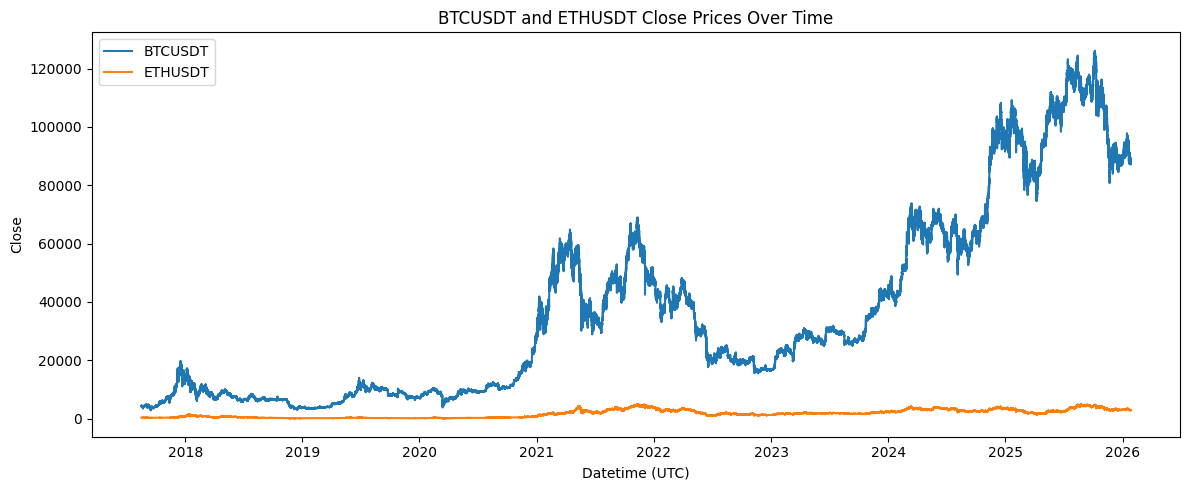

In [4]:
plt.figure(figsize=(12, 5))
plt.title("BTCUSDT and ETHUSDT Close Prices Over Time")
plt.plot(btc_df["open_time"], btc_df["close"], label="BTCUSDT")
plt.plot(eth_df["open_time"], eth_df["close"], label="ETHUSDT")
plt.xlabel("Datetime (UTC)")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()

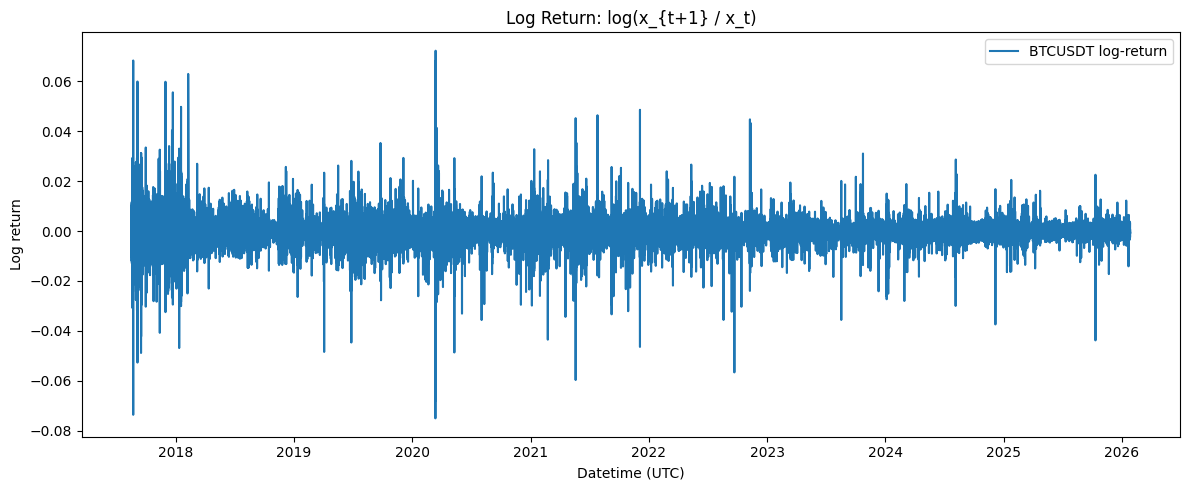

In [5]:
plt.figure(figsize=(12, 5))
plt.title("Log Return: log(x_{t+1} / x_t)")

# log return aligned to time t (last row becomes NaN due to shift(-1))
btc_change = np.log(btc_df["close"].shift(-1) / btc_df["close"]).dropna()
btc_change_time = btc_df.loc[btc_change.index, "open_time"]

plt.plot(btc_change_time, btc_change, label="BTCUSDT log-return")
# eth_change = np.log(eth_df["close"].shift(-1) / eth_df["close"]).dropna()
# eth_change_time = eth_df.loc[eth_change.index, "open_time"]
# plt.plot(eth_change_time, eth_change, label="ETHUSDT log-return")

plt.xlabel("Datetime (UTC)")
plt.ylabel("Log return")
plt.legend()
plt.tight_layout()
plt.show()

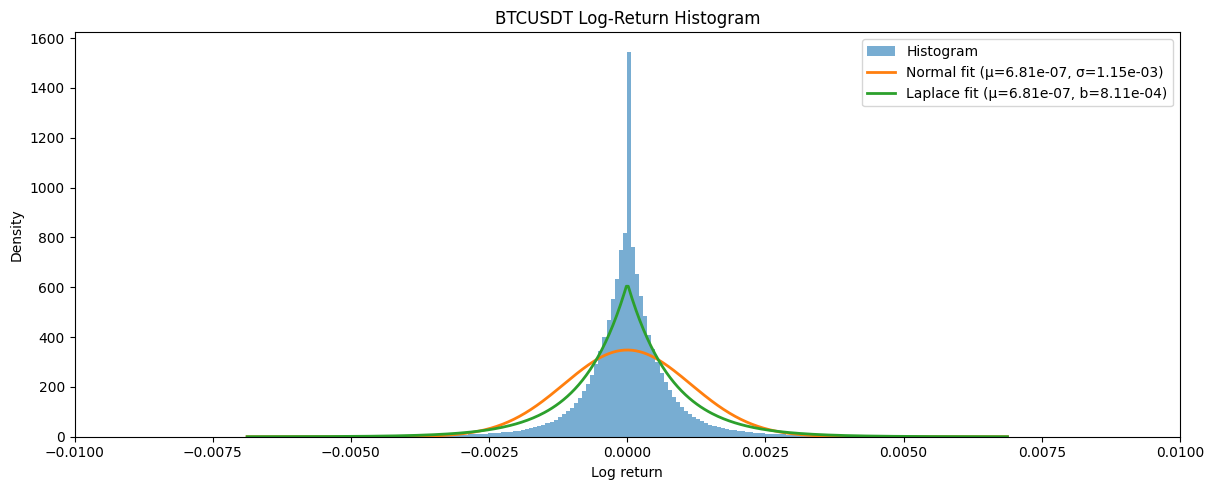

In [6]:
# Histogram (bar plot) of BTC log returns + Normal fit overlay
mu = float(btc_change.mean())
sigma = float(btc_change.std(ddof=1))

plt.figure(figsize=(12, 5))
plt.title("BTCUSDT Log-Return Histogram")
plt.hist(btc_change, bins=2000, density=True, alpha=0.6, label="Histogram")

# Normal fit overlay
x = np.linspace(mu - 6 * sigma, mu + 6 * sigma, 400)
pdf = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, pdf, linewidth=2, label=f"Normal fit (μ={mu:.2e}, σ={sigma:.2e})")

# Laplace fit overlay
b = sigma / np.sqrt(2)
laplace_pdf = (1 / (2 * b)) * np.exp(-np.abs(x - mu) / b)
plt.plot(x, laplace_pdf, linewidth=2, label=f"Laplace fit (μ={mu:.2e}, b={b:.2e})")

plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.xlim(-0.01, 0.01)
plt.show()

In [7]:
# Quick distribution diagnostics for BTC log returns
n = int(btc_change.shape[0])
skew = float(btc_change.skew())
excess_kurt = float(btc_change.kurtosis())  # excess kurtosis (0 for Normal)

print(f"n={n:,}")
print(f"mean={mu:.6e}, std={sigma:.6e}")
print(f"skew={skew:.4f}")
print(f"excess kurtosis={excess_kurt:.4f}")

# If variance changes over time, comparing distributions on volatility-standardized returns is often more meaningful.
# Use a rolling window (minutes). 1440 ~= 1 day for 1m data.
window = 1440
rolling_sigma = btc_change.rolling(window=window, min_periods=window // 2).std(ddof=1)
btc_change_z = (btc_change / rolling_sigma).dropna()

def fit_normal(x: np.ndarray) -> tuple[float, float, float, int]:
    mu_hat = float(np.mean(x))
    sigma_hat = float(np.std(x, ddof=0))
    if sigma_hat <= 0:
        return mu_hat, sigma_hat, float('-inf'), 2
    ll = float(np.sum(-0.5 * np.log(2 * np.pi) - np.log(sigma_hat) - 0.5 * ((x - mu_hat) / sigma_hat) ** 2))
    return mu_hat, sigma_hat, ll, 2

def fit_laplace(x: np.ndarray) -> tuple[float, float, float, int]:
    # MLE: location = median, scale = mean absolute deviation from location
    mu_hat = float(np.median(x))
    b_hat = float(np.mean(np.abs(x - mu_hat)))
    if b_hat <= 0:
        return mu_hat, b_hat, float('-inf'), 2
    ll = float(np.sum(-np.log(2 * b_hat) - (np.abs(x - mu_hat) / b_hat)))
    return mu_hat, b_hat, ll, 2

def compare_fits(x: np.ndarray, label: str) -> None:
    print()
    print(f"=== Fit comparison on {label} (n={x.size:,}) ===")
    fits = []

    n_mu, n_sigma, n_ll, n_k = fit_normal(x)
    n_aic = 2 * n_k - 2 * n_ll
    fits.append(("normal", n_aic, n_ll, {"mu": n_mu, "sigma": n_sigma}))

    l_mu, l_b, l_ll, l_k = fit_laplace(x)
    l_aic = 2 * l_k - 2 * l_ll
    fits.append(("laplace", l_aic, l_ll, {"mu": l_mu, "b": l_b}))

    # Student-t is a common heavier-tail alternative (optional, requires SciPy for stable fitting).
    try:
        from scipy import stats
        # Fit returns (df, loc, scale)
        t_df, t_loc, t_scale = stats.t.fit(x)
        t_ll = float(np.sum(stats.t.logpdf(x, df=t_df, loc=t_loc, scale=t_scale)))
        t_k = 3
        t_aic = 2 * t_k - 2 * t_ll
        fits.append(("student_t", t_aic, t_ll, {"df": float(t_df), "loc": float(t_loc), "scale": float(t_scale)}))
    except Exception:
        pass

    fits_sorted = sorted(fits, key=lambda r: r[1])  # lowest AIC wins
    for name, aic, ll, params in fits_sorted:
        params_str = ", ".join([f"{k}={v:.4g}" for k, v in params.items()])
        print(f"{name:10s}  AIC={aic:12.2f}  logL={ll:12.2f}  {params_str}")
    print(f"Best by AIC: {fits_sorted[0][0]}")

    # Optional: KS test with fitted distributions (requires SciPy).
    try:
        from scipy import stats
        print("KS test (larger p-value => less evidence against the model)")
        # Normal
        _, _, _, n_params = fit_normal(x)
        ks_stat, ks_p = stats.kstest(x, "norm", args=(n_mu, n_sigma))
        print(f"normal     KS={ks_stat:.4f}, p={ks_p:.3g}")
        # Laplace
        ks_stat, ks_p = stats.kstest(x, "laplace", args=(l_mu, l_b))
        print(f"laplace    KS={ks_stat:.4f}, p={ks_p:.3g}")
        # Student-t if present
        if any(name == "student_t" for name, *_ in fits):
            ks_stat, ks_p = stats.kstest(x, "t", args=(t_df, t_loc, t_scale))
            print(f"student_t  KS={ks_stat:.4f}, p={ks_p:.3g}")
    except Exception as e:
        print("Optional: install scipy for KS tests and Student-t fit.")
        print(f"scipy skipped: {type(e).__name__}: {e}")

# Compare on raw returns and on volatility-standardized returns
compare_fits(btc_change.to_numpy(), label="raw log returns")
compare_fits(btc_change_z.to_numpy(), label=f"volatility-standardized (rolling std window={window})")

n=4,431,801
mean=6.813628e-07, std=1.146398e-03
skew=0.1055
excess kurtosis=118.8203

=== Fit comparison on raw log returns (n=4,431,801) ===
student_t   AIC=-51123285.31  logL= 25561645.66  df=1.666, loc=3.615e-07, scale=0.000393
laplace     AIC=-50694227.70  logL= 25347115.85  mu=0, b=0.0006036
normal      AIC=-47439696.03  logL= 23719850.02  mu=6.814e-07, sigma=0.001146
Best by AIC: student_t
KS test (larger p-value => less evidence against the model)
normal     KS=0.1483, p=0
laplace    KS=0.0387, p=0
student_t  KS=0.0268, p=0

=== Fit comparison on volatility-standardized (rolling std window=1440) (n=4,431,082) ===
laplace     AIC= 11534669.63  logL= -5767332.81  mu=0, b=0.676
student_t   AIC= 11563927.34  logL= -5781960.67  df=2.891, loc=0.0002274, scale=0.6172
normal      AIC= 12867738.19  logL= -6433867.10  mu=0.0008564, sigma=1.034
Best by AIC: laplace
KS test (larger p-value => less evidence against the model)
normal     KS=0.0765, p=0
laplace    KS=0.0255, p=0
student_t  KS=